In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.4.1
TFP version: 0.12.1


# Probabilistic layers and Bayesian neural networks

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [ ]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

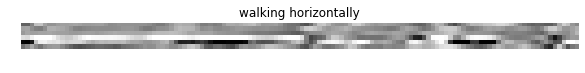

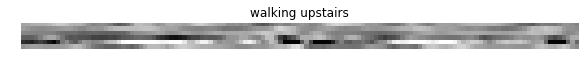

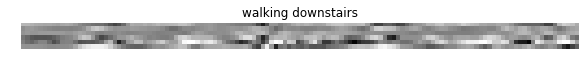

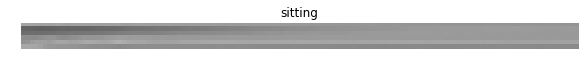

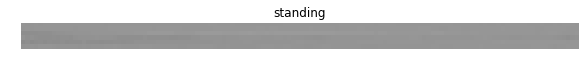

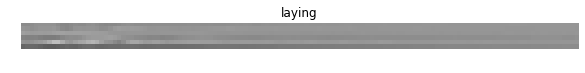

In [4]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network

In [5]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [12]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda p, q, _: tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(input_shape=(128, 6),
                            filters=8,
                            kernel_size=16,
                            activation='relu',
                            kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                            kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False), # if is_singular=True the variance of the distribution will be zero and so the distribution is collapsed to a deterministic value (the mean with probability 1) 
                            kernel_divergence_fn=divergence_fn,
                            bias_prior_fn = tfpl.default_multivariate_normal_fn,
                            bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                            bias_divergence_fn=divergence_fn),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(6), activation=None,
                            kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                            kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False), # if is_singular=True the variance of the distribution will be zero and so the distribution is collapsed to a deterministic value (the mean with probability 1) 
                            kernel_divergence_fn=divergence_fn,
                            bias_prior_fn = tfpl.default_multivariate_normal_fn,
                            bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                            bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)
    
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_3  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization (De (None, 6)                 684       
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


We have exactly twice as many parameters because each weight is replaced by an independent normal distribution which has two parameters.

In [13]:
# Replace analytical Kullback-Leibler divergence with approximated one

# This is the Monte Carlo approximation of the KL divergence
# It samples from q (q_tensor) and calculates the mean across those
# samples mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [14]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [ ]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

#### Inspect model performance

In [18]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


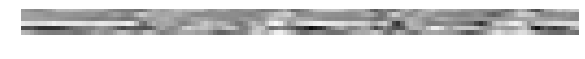

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


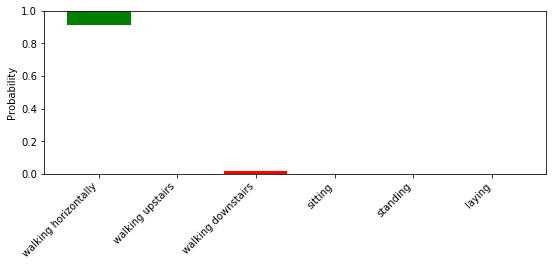

In [23]:
analyse_model_predictions(image_num=79)

This plot shows both the aleatoric and the epistemic uncertainty. The aleatoric uncertainty is showned simply by the resulting probability values. The epistemic uncertainty is the uncertainty in the weights. The function is runned 100 times to create a 95% prediction interval for the probability. In the case above there is few aleatoric uncertainty as we are very close to 100% certainty that the image is the activity _walking horizontally_. At the same time the bar is very small, so there is also small epistemic uncertainty - we see that the 95% interval for the probability goes from 90% to 100%.


------------------------------
Accelerometer data:


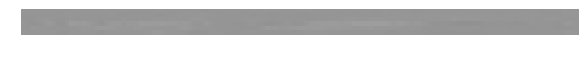

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


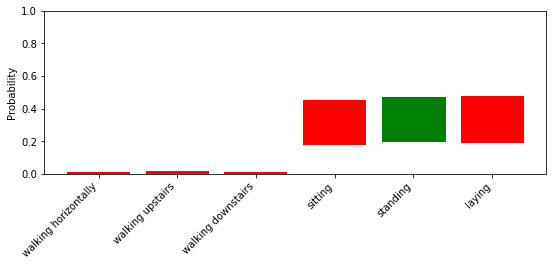

In [24]:
analyse_model_predictions(image_num=633)

In this case, we have high aleatoric uncertainty - _sitting_, _standing_ and _laying_ have more of less 33% probability each. At the same time there is significant epistemic uncertainty in each, as their values vary from about 20% to 45% probability (95% interval).

------------------------------
Accelerometer data:


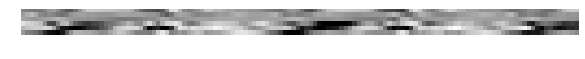

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


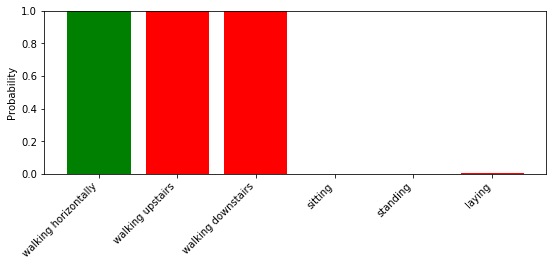

In [25]:
analyse_model_predictions(image_num=1137)

In this case, the epistemic uncertainty is huge, as the model can really distinguish between the 3 first activities. The model is basically saying: with the data that was provided (recall that epistemic uncertainty comes from imperfect training data) I can't give reliable probabilities for the different events; to be able to classify this image in these classes I need more training data. So the model knows what he does not know. This is very relevant for the bias probelm in Machine Learning.